# 1 Загрузка библиотек

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
#from matplotlib import style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns 
%matplotlib inline

# импорт библиотеки для нормализации данных
from sklearn import preprocessing

# импортруем библиотеки для статистических тестов
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from sklearn import datasets

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# Модуль для работы с координатами
from geopy.geocoders import Nominatim
from functools import partial

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 2 Определение функций

In [4]:
# Определем функции

def tags (tg_data):
    """Функция удаляет пробелы, скобки и кавычки

    Args:
        series: str с тегами
    """
    tg_data = tg_data[2:-2]
    tg_data = tg_data.replace("[' ", "").replace(" ']", '').replace("'", "")#.replace(" ", "")
    tg_data = tg_data.split(", ")
    #tagses = pd.DataFrame(tg__data)
    return tg_data

# функция для принятия решения об отклонении нулевй гипотизы
def decision_gipothesis(p):
    """Функция определяет верность гипотез

    Args:
        p (p-value): значение-результат статистического теста, с помощью которого определяется выбор гипотезы
    """
    
    print(f"p-value = {p:.3f}")
    if p <= alpha:
        print(f"р-значение меньше, чем заданный уровень значимости {alpha:.2}. Отвергаем нулевую гипотезу в пользу альтернативной.")
    else:
        print(f"р-значение больше, чем заданный уровень значимости {alpha:.2}. У нас нет оснований отвергнуть нулевую гипотезу.")
        
        
def get_lower_words (review):
    """Функция преобразовывает текст в строчные буквы и убирает пробелы в начале и конце строк

    Args:
        review (series): str с текстом отзыва
    """
    
    review = review.lower().strip()
    return review


# задаем уровень значимости 5%
alpha = 0.05

def get_coord(row):
    """Функция заполняет пропущенные значения в координатах отеля lat  и lng

    Args:
        row (_type_): словарь, где наименование - ключ, значение - координаты lat и lng

    Returns:
        _type_: значение координаты float
    """
    if pd.isna(row.lat):
        row.lat = coord_dict[row.hotel_name][0]
        row.lng = coord_dict[row.hotel_name][1]
    return row

# 3 Чтение данных

In [5]:
# Подгрузим наши данные из соревнования
'''
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн
'''

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн


## 3.1 Ознакомление с дата-сетами

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 4 Обработка данных

## 4.1 Объединение тренировочного и тестового дата-сетов

In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/3686891825.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В дата-фрейме обнаружены пропуски значений в признаках "lat" и "lng"
<br> Также в дата-фрейме содержаться 8 признаков типа "object" и 10 числовых признаков.

In [14]:
data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0


## 4.2 Создадим два списка признаков типов "object" и "int"

In [15]:
# проанализируем какие признаки категориальный либо цифровые
obj = []
num = []
for i in data.columns:
    if data[i].dtypes  == 'object':
        obj.append(i)
    else:
        num.append(i)
print(f'Столбцы "object":\n {obj}')
print()
print(f'Столбцы "numeric":\n {num}')

Столбцы "object":
 ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']

Столбцы "numeric":
 ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score']


Исследуем структуру информации в признаках типа "object"

In [16]:
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
" United Kingdom "

negative_review
" Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices "

positive_review
" Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again "

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



В признаках (reviewer_nationality, negative_review, positive_review, tags) присутсвуют пробелы перед и после значений, удалим эти пробелы
В признаке "tags" удалим пробелы после поиска дублей, т.к. после преобразоания данного признака значения становятся списком и функция поиска дубликатов выдает ошибку.

In [17]:
# удаление пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply (lambda x: x.strip())
data['negative_review'] = data['negative_review'].apply (lambda x: x.strip())
data['positive_review'] = data['positive_review'].apply (lambda x: x.strip())
#data['tags'] = data['tags'].apply (lambda x: x.replace("[' ", "").replace(" ']", '').split(" ', ' "))

In [18]:
#Проверка на удаление пробелов
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
"United Kingdom"

negative_review
"Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices"

positive_review
"Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again"

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



Пробелы удалены

## 4.3 Поиск дубликатов в дата-сете

In [19]:
dupl_col = list(data.columns)

mask = data.duplicated(subset=dupl_col)
data_dupl = data[mask]

print(f'Число найденных дубликатов: {data_dupl.shape[0]}')

Число найденных дубликатов: 336


По правилам соревнования удалять строки не можем. Дублирующие записи пометим "1"

In [20]:
data['duplicates'] = mask.apply(lambda x: 1 if x else 0)
print((data['duplicates'].value_counts())[1]) # проверка суммой количество дублирующих строк

336


## 4.4 Поиск пропусков в признаках

<AxesSubplot:>

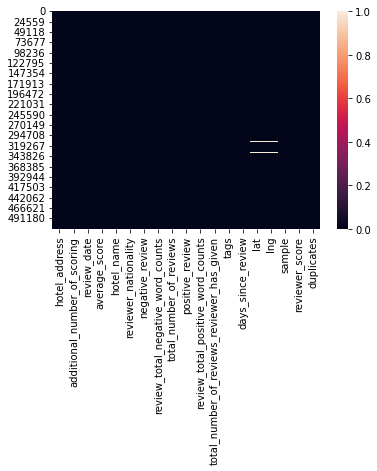

In [21]:
sns.heatmap(data.isnull()) # наглядная карта пропусков

In [22]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
duplicates                                       0
dtype: int64

Обнаружены пропуски в признаках "lat" и "lng"

## 4.5 Преобразование даты "review_date"

In [23]:
# Преобразуем признак в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [24]:
# из признака даты сформируем два отдельных признака год и месяц

# формирование признака "месяц"
data['review_month'] = data['review_date'].dt.month

# формируе признак "год"
data['review_year'] = data['review_date'].dt.year

# удаление признака "review_date"
data.drop('review_date', axis=1, inplace=True)

# проверка
data.info()
# признаки "месяц" и "год" созданы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.6 Преобразование адреса отеля "hotel_address"

In [25]:
# анализ структуры записи адреса отеля

print(data['hotel_address'][0])
print(data['hotel_address'][10])
# последнее слово - страна, предпоследнее слово - город

Via Senigallia 6 20161 Milan Italy
Via Giorgio Stephenson 55 20157 Milan Italy


In [26]:
# сформируем два новых признака "country" и "city"
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])

# проверка
data[['country', 'city']]
# новые признаки сформированы
# некорректно обработалось наименование United Kongdom

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,Kingdom,United
515734,Austria,Vienna
515735,Kingdom,United
515736,Kingdom,United


In [27]:
# коррекция признаков "country" и "city"

data['country'] = data['country'].apply(lambda x: 'UK' if x == 'Kingdom' else x)
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)

# проверка
data[['country', 'city']]

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,UK,London
515734,Austria,Vienna
515735,UK,London
515736,UK,London


## 4.7 Кодирование признаков "country" и "city"

In [28]:
# выясним количество уникальных значений стран и городов
display(f'Уникальное количество стран: {data["country"].nunique()}: {data["country"].unique()}')
display(f'Уникальное количество городов: {data["city"].nunique()}: {data["city"].unique()}')

# в данном дата-сете один город - одна страна, скорей всего между этими признаками будет мультиколлениарность

"Уникальное количество стран: 6: ['Italy' 'Netherlands' 'Spain' 'UK' 'France' 'Austria']"

"Уникальное количество городов: 6: ['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']"

In [29]:
# кодируем посредством создания списка наименований будущих признаков и lambda-функции

# создаем список стран
country_list = list(data['country'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование стран строчными буквами
for i in country_list:
    country_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[country_col] = data['country'].apply(lambda x: 1 if i == x else 0)

In [30]:
# создаем список городов
city_list = list(data['city'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование городов строчными буквами
for i in city_list:
    city_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[city_col] = data['city'].apply(lambda x: 1 if i == x else 0)

## 4.8 Добавление дополнительных признаков населения стран и городов

In [31]:
# Добавим три признака:
# население страны,
# население города,
# соотношение населения города к населению страны

# словарь население стран
country_popul = {
    'UK': 665111098,
    'Netherlands': 17032845,
    'France': 64938716,
    'Spain': 46070146,
    'Italy': 59797978,
    'Austria': 8592400
}

data['country_popul'] = data['country'].map(country_popul)


# словарь население городов
сity_popul = {
    'Paris': 2187526,
    'London': 8825000,
    'Milan': 1378000,
    'Vienna': 1888776,
    'Barcelona': 1628936,
    'Amsterdam': 1123000
}

data['сity_popul'] = data['city'].map(сity_popul)

# соотношение населения города к населению страны
data['diff_popul'] = round(data['сity_popul'] / data['country_popul'], 4) # округлим до 4 знаков

In [32]:
data.head(1)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,austria,milan,amsterdam,barcelona,london,paris,vienna,country_popul,сity_popul,diff_popul
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,1,0,0,0,0,0,59797978,1378000,0.023


## 4.9 Восстановление пропущенных признаков координат городов

In [33]:
# создадим дата-сет с пропущенными координатами отелей
hotel_geo = data[(data['lat'].isna()) & (data['lng'].isna())]['hotel_name']
display(f"Количество отелей с пропущенными координатами: {hotel_geo.nunique()}")
print(f"Перечень уникальных наименований отелей с пропущенными координатами: \n {hotel_geo.unique()}")

'Количество отелей с пропущенными координатами: 17'

Перечень уникальных наименований отелей с пропущенными координатами: 
 ['Hotel Atlanta' 'City Hotel Deutschmeister'
 'Holiday Inn Paris Montmartre' 'Fleming s Selection Hotel Wien City'
 'Hotel City Central' 'Cordial Theaterhotel Wien'
 'NH Collection Barcelona Podium' 'Hotel Daniel Vienna'
 'Maison Albar Hotel Paris Op ra Diamond'
 'Mercure Paris Gare Montparnasse' 'Hotel Pension Baron am Schottentor'
 'Austria Trend Hotel Schloss Wilhelminenberg Wien'
 'Renaissance Barcelona Hotel'
 'Derag Livinghotel Kaiser Franz Joseph Vienna' 'Roomz Vienna'
 'Hotel Park Villa' 'Hotel Advance']


In [34]:
# создадим словарь, где ключ-наименование отеля, значения - координаты отеля
coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [35]:
# заполняем пропуски в значения координат lat и lng с помощью функции
data = data.apply(lambda row: get_coord(row), axis=1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

<AxesSubplot:>

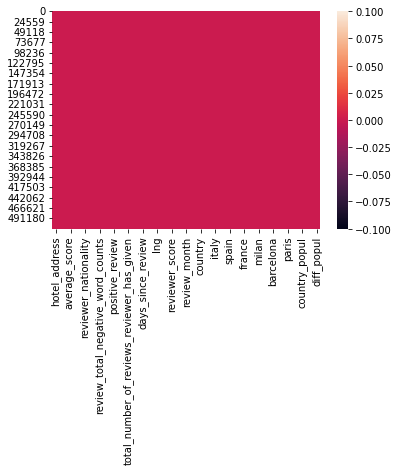

In [37]:
# проверка дата-сета на наличие пропусков
sns.heatmap(data.isnull())

# пропусков не обнаружено

In [38]:
#Удалим признаки с пропусками "lat" и "lng"
#data = data.drop(['lat', 'lng'], axis=1)
#sns.heatmap(data.isnull())

## 4.10 Анализ национальности (гражданства) посетителей отелей

In [39]:
# Произведем подсчет уникальных значений национальностей посетителей
print(f'Количество уникальных значений национальностей посетителей отелей: {data["reviewer_nationality"].nunique()}')

Количество уникальных значений национальностей посетителей отелей: 227


In [40]:
# отбирем 15 самых часто встречаемых значений национальности, остальным присвоим значение other и закодируем
data['reviewer_nationality'].value_counts().head(20)

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
Name: reviewer_nationality, dtype: int64

In [41]:
# изменим значение национальность - United Kingdom на UK, чтобы в дальшейшем корректно отобразить внутрених туристов UK == UK
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'UK' if x == 'United Kingdom' else x)

In [42]:
# создадим дата-сет с 15 часто встречаемых значений
national_15 = data['reviewer_nationality'].value_counts().nlargest(15).index

# заменим другие национальности значением other
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in national_15 else 'Other')

In [43]:
# чтобы не создавать 15 новых колонок применим бинарное кодирование к признаку "reviewer_nationality"
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [44]:
# создадим признак для посетителей отелей внутри своей страны
data['local_reviewer'] = data['reviewer_nationality'] == data['country']
#data['local_reviewer'].value_counts()

# преобразуем признак local_reviewer из bool в int8
data = data.astype({'local_reviewer':np.int8})

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.11 Анализ отзывов об отелях

In [46]:
# исследуем в дата-сете информацию об отзывах
'''display(data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']])'''
            

all_review = data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']]
all_review.head()
# первичный анализ показывает, к примеру, в строке три количество слов не соответствует указанному значению
# в строке  2 отзыв по смылслу не позитивный, но указан в столбце позитивных отзывов, т.е. необходимо также проверить отзывы по смыслу
# посетители указывают, что конкретно им нравится или не нравится, к примеру, комната, персонал, сервис и т.д.

,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,1
1,No tissue paper box was present at the room,10,5018,No Positive,0,7
2,Pillows,3,351,Nice welcoming and service,5,15
3,No Negative,0,1543,Everything including the nice upgrade The Hote...,27,9
4,No Negative,0,4687,Lovely hotel v welcoming staff,7,2


In [47]:
# проверка предположения, что указано ошибочное количество слов отзыва.
# в предыдущем запросе указано значение 52, в действительности 50
len((data['negative_review'][0].split()))

50

In [48]:
# произведем коррекцию значений в столбцах по уоличеству слов в отзывах
#df = data.copy()
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split()))

In [49]:
# проверка
data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']].head()

# данные откорректированы

,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,Would have appreciated a shop in the hotel tha...,50,16670,Hotel was great clean friendly staff free brea...,60,1
1,No tissue paper box was present at the room,9,5018,No Positive,2,7
2,Pillows,1,351,Nice welcoming and service,4,15
3,No Negative,2,1543,Everything including the nice upgrade The Hote...,26,9
4,No Negative,2,4687,Lovely hotel v welcoming staff,5,2


In [50]:
# преобразуем текст отзывов в строчные буквы
data['negative_review'] = data['negative_review'].apply(get_lower_words)
data['positive_review'] = data['positive_review'].apply(get_lower_words)


In [51]:
# откорректируем смысл отзывов, т.е. в найдем положительные отзывы в негативных и наоборот

# анализируем самые частые формулировки
data['negative_review'].value_counts().head(30)
# наблюдаем большое количество отзывов с НЕ отрицательным смыслом
# наблюдаем негативные отзывы в отношении комнаты, цены, локации, еды,персонала и т.д. - далее закодируем данные признаки


no negative                  127890
nothing                       21185
n a                            1815
none                           1501
                                849
nothing really                  656
small room                      570
all good                        545
breakfast                       545
no complaints                   523
location                        502
nothing at all                  467
everything                      420
nothing to dislike              373
price                           348
nil                             332
small rooms                     307
everything was perfect          276
na                              272
can t think of anything         250
leaving                         244
absolutely nothing              242
everything was great            222
expensive                       206
nothing to complain about       205
no                              200
very small room                 200
room size                   

In [52]:
# создадим список НЕ негативных выражений

not_negative_review = ['no negative', 'nothing', 'n a', 'none', '', 'no', 'no complaints', 'nil', 'nothing really',
                       'all good', 'na', 'nothing at all', 'everything was perfect', 'can t think of anything',
                       'absolutely nothing','everything was perfect', 'nothing to dislike',
                       'nothing to complain about', 'everything was great', 'nothing not to like',
                       'liked everything', 'everything was great', 'absolutely nothing','everything was good',
                       'all was good', 'i liked everything', 'nothing to complain about', 'no thing',
                       'nothing not to like', 'nothing everything was perfect', 'nothing everything was great',
                       'all ok', 'nothing it was perfec', 'i liked everything', 'nothing it was perfect',
                       'everything was good', 'nothing i didn t like', 'everything was fine',
                       'nothing everything was perfect', 'there was nothing i didn t like', 'nothing comes to mind',
                       'no dislikes', 'no comment', 'no negatives', 'not a thing', 'nothing to mention',
                       'nothing comes to mind', 'nothing to report', 'no complaints at all']

In [53]:
# создадим временный признак-"копия негативных отзывов" для отделения истинно негативных от НЕ негативных
data['negative_review_copy'] = data['negative_review'].apply(lambda x: '1' if x in not_negative_review else x)

In [54]:
# анализ причин жалоб посетителей
data['negative_review_copy'].value_counts().head(20)

1                      160082
small room                570
breakfast                 545
location                  502
everything                420
price                     348
small rooms               307
leaving                   244
expensive                 206
room size                 200
very small room           200
nothing all good          181
staff                     181
having to leave           176
not much                  159
see above                 141
expensive breakfast       138
non                       134
the price                 132
room too small            127
Name: negative_review_copy, dtype: int64

In [55]:
# в рамках данного исследования выберим несколько пунктов: комната, душевая, локация, персонал, цена, питание

# жалобы на номер
data['neg_room'] = data['negative_review_copy'].apply(lambda x: 1 if ('room' in x) or ('bed' in x) or ('beds' in x) or ('old' in x) else 0) 
#display(data['neg_room'].value_counts())

# жалобы на локацию
data['neg_location'] = data['negative_review_copy'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
#display(data['neg_location'].value_counts())

# жалобы на персонал и уборку
data['neg_staff'] = data['negative_review_copy'].apply(lambda x: 1 if ('staff' in x)
                                                      or ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0) 
#display(data['neg_staff'].value_counts())

# жалобы на питание
data['neg_eat'] = data['negative_review_copy'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x)
                                                    or ('dinner' in x) or ('lunch' in x) or ('meal' in x) else 0)
#display(data['neg_eat'].value_counts())
        
# жалобы на стоимость
data['neg_price'] = data['negative_review_copy'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) or ('cost' in x) else 0)
#display(data['neg_price'].value_counts())


# жалобы на интернет
data['neg_wifi'] = data['negative_review_copy'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x)
                                                      or ('wi fi' in x) or ('wifi' in x) else 0) 
#display(data['neg_wifi'].value_counts()) # проверяем работу lambda-функции


# жалобы на ванную и душевую
data['neg_bath'] = data['negative_review_copy'].apply(lambda x: 1 if ('bath' in x) or ('toilet' in x) else 0) 
#display(data['neg_bath'].value_counts())

# жалобы "всё плохо"
data['neg_all'] = data['negative_review_copy'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
#display(data['neg_all'].value_counts())

# данное распределение может помочь понять на что именно жалуются посетители и принять соответствующие решения со стороны руководства отелей


In [56]:
# создадим список НЕ позитивных выражений

not_positive_review = ['no positive', 'nothing', 'n a', 'none', 'no', 'no complaints', ' ', '']

# создадим временный признак-"копия позитивных отзывов" для отделения истинно позитивных от НЕ позитивных
data['positive_review_copy'] = data['positive_review'].apply(lambda x: '1' if x in not_positive_review else x)

In [57]:
# анализ причин причин положительных отзывов посетителей
data['positive_review_copy'].value_counts().head(20)

1                             38004
location                      11945
everything                     3314
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
the staff                       281
Name: positive_review_copy, dtype: int64

In [58]:
# в рамках данного исследования выберим несколько пунктов: комната, душевая, локация, персонал, цена, питание

# понравился номер
data['pos_room'] = data['positive_review_copy'].apply(lambda x: 1 if ('room' in x) or ('bed' in x) or ('beds' in x) or ('old' in x) else 0) 
#display(data['pos_room'].value_counts())

# # понравилась локация
data['pos_location'] = data['positive_review_copy'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
#display(data['pos_location'].value_counts())

# понравился персонал и уборка
data['pos_staff'] = data['positive_review_copy'].apply(lambda x: 1 if ('staff' in x)
                                                      or ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0) 
#display(data['pos_staff'].value_counts())

# понравилось питание
data['pos_eat'] = data['positive_review_copy'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x)
                                                    or ('dinner' in x) or ('lunch' in x) or ('meal' in x) else 0)
#display(data['pos_eat'].value_counts())
        
# понравилась стоимость
data['pos_price'] = data['positive_review_copy'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) or ('cost' in x) else 0)
#display(data['pos_price'].value_counts())


# понравился интернет
data['pos_wifi'] = data['positive_review_copy'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x)
                                                      or ('wi fi' in x) or ('wifi' in x) else 0) 
#display(data['pos_wifi'].value_counts()) # проверяем работу lambda-функции


# понравились ванная/душевая и туалет
data['pos_bath'] = data['positive_review_copy'].apply(lambda x: 1 if ('bath' in x) or ('toilet' in x) else 0) 
#display(data['pos_bath'].value_counts())

# "всё понравилось"
data['pos_all'] = data['positive_review_copy'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
#display(data['pos_all'].value_counts())

# данное распределение может помочь понять, что именно понравилось посетителям и рекламировать эти конкурентные преимущества

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.12 Анализ тегов

In [60]:
def tags (tg_data):
    
    tg_data = tg_data[2:-2]
    tg_data = tg_data.replace("[' ", "").replace(" ']", '').replace("'", "")#.replace(" ", "")
    tg_data = tg_data.split(", ")
    #tagses = pd.DataFrame(tg__data)
    return tg_data

In [61]:
# преобразуем теги тип переменной из str в list
df = data[['tags']].copy()
df.info()

df['lst_tags'] = df['tags'].apply(tags)
df_tg = df.explode('lst_tags')
df_tg['lst_tags'][0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tags    515738 non-null  object
dtypes: object(1)
memory usage: 3.9+ MB


0        Leisure trip 
0              Couple 
0         Double Room 
0     Stayed 2 nights 
Name: lst_tags, dtype: object

In [62]:
# анализ количества тегов
df_tg['lst_tags'].value_counts().head(25)

 Leisure trip                       417778
 Submitted from a mobile device     307640
 Couple                             252294
 Stayed 1 night                     193645
 Stayed 2 nights                    133937
 Solo traveler                      108545
 Stayed 3 nights                     95821
 Business trip                       82939
 Group                               65392
 Family with young children          61015
 Stayed 4 nights                     47817
 Double Room                         35207
 Standard Double Room                32248
 Superior Double Room                31393
 Family with older children          26349
 Deluxe Double Room                  24823
 Double or Twin Room                 22393
 Stayed 5 nights                     20845
 Standard Double or Twin Room        17483
 Classic Double Room                 16989
 Superior Double or Twin Room        13570
 2 rooms                             12393
 Stayed 6 nights                      9776
 Standard T

In [63]:
# в рамках данного исследования экспертным путем выделим 10 основных тегов и закодируем их

# путешествие - отдых
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)

# отдых на две персоны
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)

# отдых одной персоны
data['solo_traveler'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)

# Бизнес-поездка
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

# Отдых компанией
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)

# Семейный отдых с меленькими детьми
data['family_young_children'] = data['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)

# Семейный отдых с детьми подростками
data['family_older_children'] = data['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)

# Одноместные номера
data['single_rooms'] = data['tags'].apply(lambda x: 1 if 'Single' in x else 0)

# Двухместные номера
data['double_rooms'] = data['tags'].apply(lambda x: 1 if 'Double' in x else 0)

# Стандартные номера
data['standart_rooms'] = data['tags'].apply(lambda x: 1 if 'Standard' in x else 0)

# Классические номера
data['classic_rooms'] = data['tags'].apply(lambda x: 1 if 'Classic' in x else 0)

# Супер номера
data['super_rooms'] = data['tags'].apply(lambda x: 1 if 'Superior' in x else 0)

# Роскошные номера
data['luxury_rooms'] = data['tags'].apply(lambda x: 1 if 'Luxury' in x else 0)

In [64]:
# из тегов определим на какое количество ночей приезжали посетители

data['number_nights'] = data['tags'].str.extract(r'Stayed (\d+) night').fillna(1).astype(int)
# в 192 случаях количество ночей не указано, поэтому заменим пропуски модой, т.е. 1.
# Т.к. в отель заселяются минимум на одну ночь

# 5. Визуализация и статистическое исследование

## 5.1 Визуальный анализ (графики)

<AxesSubplot:title={'center':'Количество негативных отзывов по категориям'}>

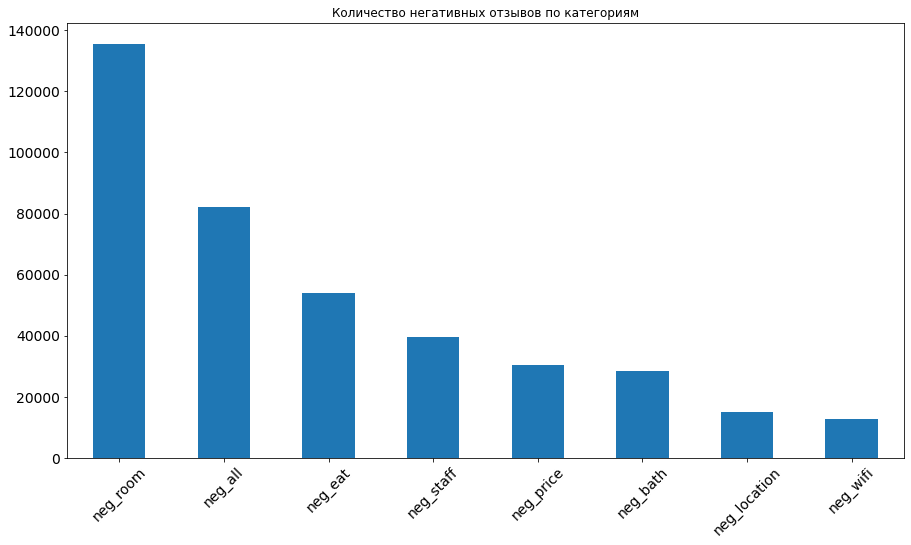

In [65]:
# визуализируем отрицателные отзывы по категориям
data_neg = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

x_neg = data_neg.loc[:, 'neg_room':'neg_all']
d_neg = x_neg.sum()
d_neg.sort_values(ascending=False, inplace=True)
d_neg.plot(kind='bar',
       figsize=(15, 8),
       fontsize = 14,
       rot=45,
       title='Количество негативных отзывов по категориям')

# график показывает каких жалоб больше и позволяет определить приоритетные направления развития отелей
# руководству отеля необходимо братить внимание на качество номеров, еды и работу персонала в первую очередь
# анализ возможно проводить по странам и городам в отдельности
# отзыв "neg_all" можно не учитывать, т.к. он не содержит конкретики

<AxesSubplot:title={'center':'Количество положительных отзывов по категориям'}>

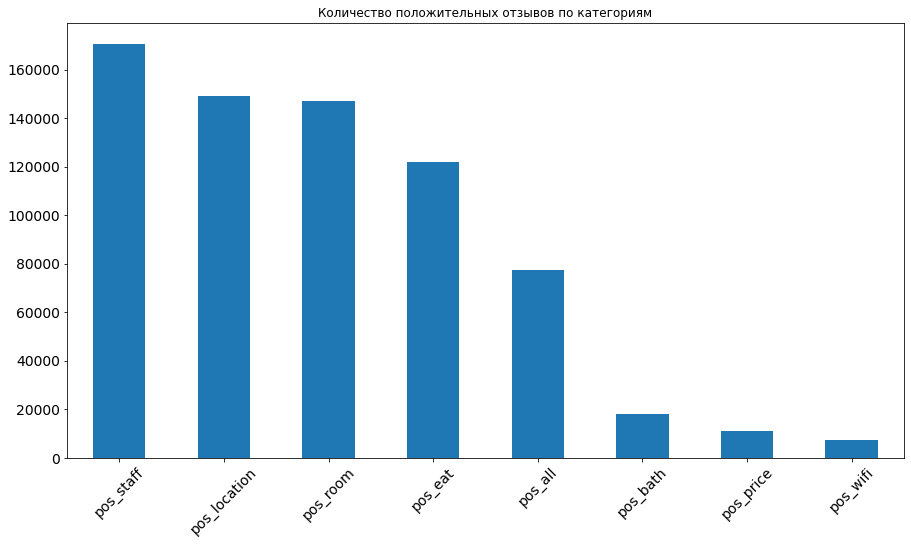

In [66]:
# визуализируем положительных отзывы по категориям

data_pos = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

x_pos = data_pos.loc[:, 'pos_room':'pos_all']
d_pos = x_pos.sum()
d_pos.sort_values(ascending=False, inplace=True)
d_pos.plot(kind='bar',
       figsize=(15, 8),
       fontsize = 14,
       rot=45,
       title='Количество положительных отзывов по категориям')

# график показывает, что больше всего понравилось посетителям
# в рекламе отеля можно использовать его сильные стороны: доброжелательный персонал, удобная локация, комфорт номеров, вкусная еда
# отзыв "pos_all" можно не учитывать, т.к. он не содержит конкретики

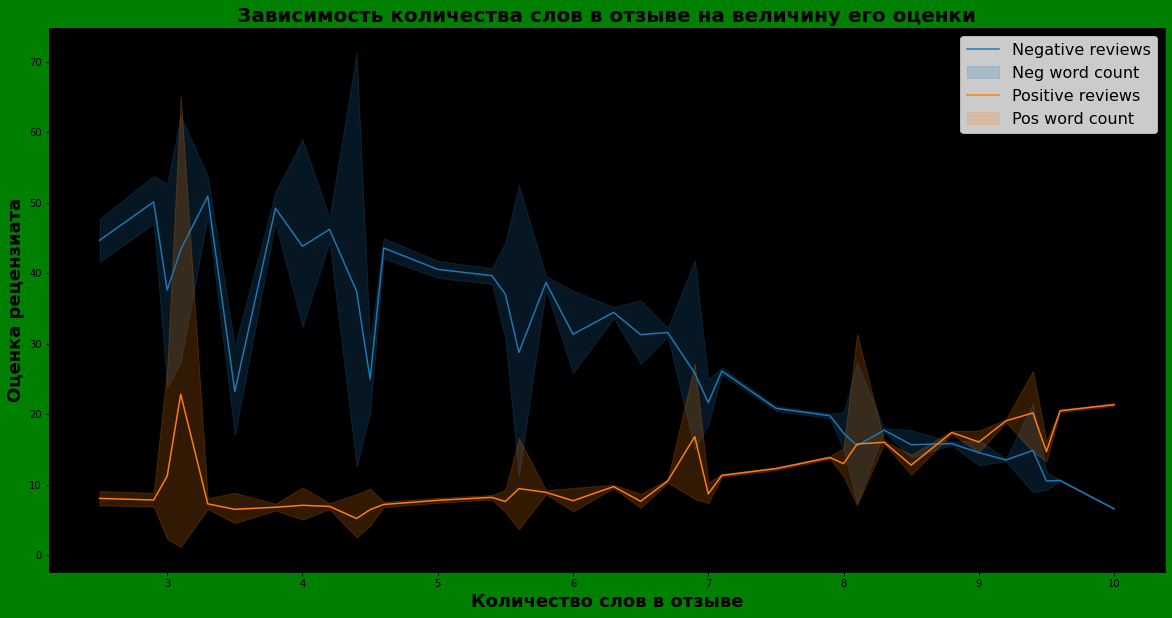

In [67]:
# Проведем визуальный анализ зависимости количество слов в отзыве на его оценку
df = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

#plt.style.use('dark_background')
fig, axes = plt.subplots(figsize=(20, 10), facecolor='green')

sns.lineplot(data = df, x = "reviewer_score", y = "review_total_negative_word_counts", ax=axes) # синий негатив

sns.lineplot(data = df, x = "reviewer_score", y = "review_total_positive_word_counts", ax=axes) # красный позитив

axes.set_title('Зависимость количества слов в отзыве на величину его оценки', fontsize=20, fontweight='bold')
axes.set_xlabel('Количество слов в отзыве', fontsize=18, fontweight='bold')
axes.set_ylabel('Оценка рецензиата', fontsize=18, fontweight='bold')
axes.legend(['Negative reviews', 'Neg word count', 'Positive reviews', 'Pos word count'], loc='upper right', fontsize=16)
axes.set_facecolor('black') # пробы применения фоновых цветов

plt.show() 

Данный график показывает две прямые зависимости:
1. чем больше количество слов в негативном отзыве, тем меньше оценка
2. чем больше количество слов в положительном отзыве, тем больше оценка

С помощью получившегося дата-сета можно построить множество графиков и искать закономерности, к примеру, в какой стране отели получили большую среднюю оценку, внутренний или внешний турист ставит больше баллов, в какие месяца или годы было больше оценок и т.д.

## 5.2. Гепотизы и стаистические тесты

### 5.2.1 Руководство отелей должно заботиться о повышении уровня обслуживания клиентов, чтобы увеличивать свою среднюю оценку и соотвественно увеличивать привлекательность для потенциальных посетителей

### Определим наблюдается ли ежегодный рост средной оценки отелей, на основе общего количества оценок рецензиатов (reviewer_score) с помощью статистического теста и сформируем гепотезу, где предположим, что средняя оценка ежегодно увеличивается.

In [68]:
# используем данные с тренировочного дата-сета
df_rev_year = data.loc[(data['sample'] == 1), ['review_year', 'reviewer_score']] # формируем новый дата-сет: оценка и год оценки

df_rev_year['review_year'].value_counts()

#присутствуют данные за три года и в разном количестве

2016    198215
2017    117639
2015     70949
Name: review_year, dtype: int64

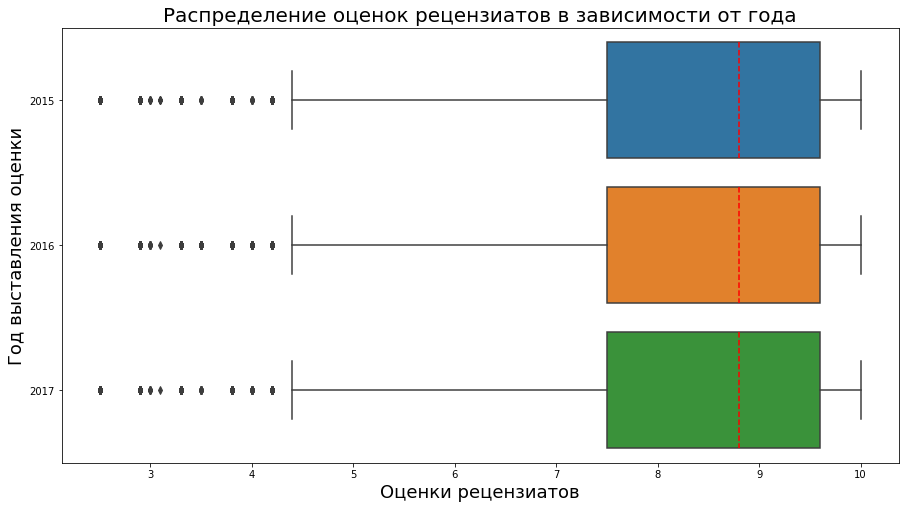

In [69]:
# Строим коробчатые диаграммы распределения оценок в зависимости от года
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=df_rev_year, x="reviewer_score", y="review_year", orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set_xlabel('Оценки рецензиатов', fontsize=18)
ax.set_ylabel('Год выставления оценки', fontsize=18)
plt.title('Распределение оценок рецензиатов в зависимости от года', fontsize=20)
plt.show()

# Анализ коробатой диагарммы показывает, что средняя на основе оценок рецензиатов по годам не изменяется
# Поялвяется предположение, что на данных 2015 года можно предполагать какие оценки будут в 2017 году и позже.


**Проверка на нормальность**
Построим квантиль-квантиль графики QQ plot

In [70]:
# создадим три дата-сета по годам
df_rev_year_2015 = df_rev_year.loc[df_rev_year['review_year']==2015]
df_rev_year_2016 = df_rev_year.loc[df_rev_year['review_year']==2016]
df_rev_year_2017 = df_rev_year.loc[df_rev_year['review_year']==2017]

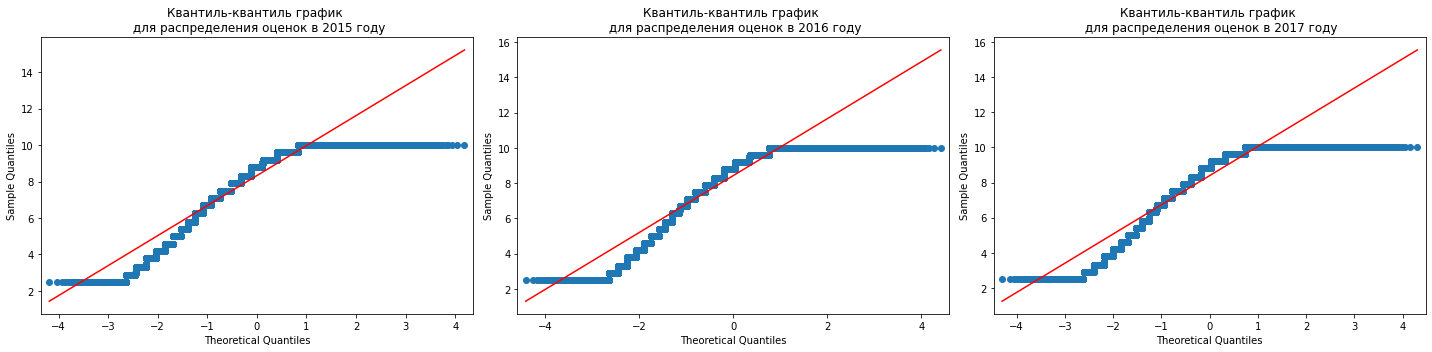

In [71]:
# задаём параметры квантиль-квантиль графика
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))

sm.qqplot(df_rev_year_2015['reviewer_score'], line='s', ax=ax1)
ax1.set_title('Квантиль-квантиль график \n для распределения оценок в 2015 году')

sm.qqplot(df_rev_year_2016['reviewer_score'], line='s', ax=ax2)
ax2.set_title('Квантиль-квантиль график \n для распределения оценок в 2016 году')

sm.qqplot(df_rev_year_2017['reviewer_score'], line='s', ax=ax3)
ax3.set_title('Квантиль-квантиль график \n для распределения оценок в 2017 году')

plt.tight_layout()
# отображаем квантиль-квантиль график
plt.show()

Графики показывают, что данные не распределены нормально и имеют одинаковый рисунок

Определим произошел ли рост средней оценки рецензиатов на протяжении 3-х лет.
<br>*Нулевая гипотеза* ($H_0$): рост средней оценки не наблюдается.
$$ H_0 : μ_1 = μ_2 = μ_3$$

<br>*Альтернативная гипотеза* ($H_1$): наблюдается рост средней оценки.
$$ H_1 : μ_1 < μ_2 < μ_3$$

In [72]:
df_rev_year['review_year'].value_counts() #дата-сеты имеют разную длину, дополним их медианными значениями до размера 2016 года

2016    198215
2017    117639
2015     70949
Name: review_year, dtype: int64

In [73]:
df_scor_2015 = df_rev_year_2015['reviewer_score']
df_scor_2016 = df_rev_year_2016['reviewer_score']
df_scor_2017 = df_rev_year_2017['reviewer_score']

In [74]:
len(df_scor_2016) - len(df_scor_2015) # дата-сет за 2015 год необходимо дополнить на 127 266 значений

127266

In [75]:
# создаем дополнительный список на 127266 значение и заполняем его медианой
df_127266 = np.full(shape = 127266, fill_value = df_scor_2015.median(), dtype = np.int)

# расширяем список на 21 значение
df = df_scor_2015
df_np = pd.DataFrame(df_127266)
ser = df_np.iloc[:,0]
df_scor_2015_ext = df.append(ser, ignore_index = True)
len(df_scor_2015_ext)# размер дата-сета соответствует дата-сету за 2016 год

C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/1976512251.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_127266 = np.full(shape = 127266, fill_value = df_scor_2015.median(), dtype = np.int)
C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/1976512251.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scor_2015_ext = df.append(ser, ignore_index = True)


198215

In [76]:
len(df_scor_2016) - len(df_scor_2017) # дата-сет за 2017 год необходимо дополнить на 80 576 значений

80576

In [77]:
# создаем дополнительный список на 127266 значение и заполняем его медианой
df_80576 = np.full(shape = 80576, fill_value = df_scor_2015.median(), dtype = np.int)

# расширяем список на 21 значение
df = df_scor_2017
df_np = pd.DataFrame(df_80576)
ser = df_np.iloc[:,0]
df_scor_2017_ext = df.append(ser, ignore_index = True)
len(df_scor_2017_ext)# размер дата-сета соответствует дата-сету за 2016 год

C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/1755864905.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_80576 = np.full(shape = 80576, fill_value = df_scor_2015.median(), dtype = np.int)
C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/1755864905.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scor_2017_ext = df.append(ser, ignore_index = True)


198215

In [78]:
# проверим длину дата-сетов
print(len(df_scor_2017_ext))
print(len(df_scor_2015_ext))
print(len(df_scor_2016))

198215
198215
198215


In [79]:
# вернем медианное значение дата-сетов
print(df_scor_2017_ext.median())
print(df_scor_2015_ext.median())
print(df_scor_2016.median())

8.0
8.0
8.8


In [80]:
# Распределение значений не соответстует нормальному.
# Тестировать будем три зависимые группы. Значит выбраем непараметрический Критерий Фридмана.
# Для проведения теста необходимо подать на вход три списка значений одинаковой длины.
# Можно в меньший список добавить необходимое количество значений 
# В рамках данного задания будем пробовать дополнять списки медианными значениями.

df_scor_2016 = df_rev_year_2016['reviewer_score'] # оценки за 2016 год выделяем в отдельный series

_, p = stats.friedmanchisquare(df_scor_2015_ext, df_scor_2016, df_scor_2017_ext)
decision_gipothesis(p)

print("Вывод: наблюдается рост средней оценки")


p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Вывод: наблюдается рост средней оценки


### 5.2.2 Руководство отелей должно понимать какие посетители (внутренние или иностранцы) ставят выше оценки, чтобы персонал уделял больше внимание одной из категории больше внимания

### Определим какие посетители (внутренние или иностранцы) ставят выше оценки, помощью статистического теста проведем провереку на нормальность распределения данных и сформируем гепотезу, где предположим, что оценки иностранцев выше, чем внутренних посетителей.

In [81]:
# используем данные из тренировочного дата-сета
# формируем новый дата-сет: оценки внутреннего и иностранного посетителя отеля
df_rev_local = data.loc[(data['sample'] == 1), ['local_reviewer', 'reviewer_score']] 
#df_rev_local.info()

In [82]:
loc_rev = df_rev_local.loc[(df_rev_local['local_reviewer'] == 1), ['reviewer_score', 'local_reviewer']]
not_loc_rev = df_rev_local.loc[(df_rev_local['local_reviewer'] == 0), ['reviewer_score', 'local_reviewer']]

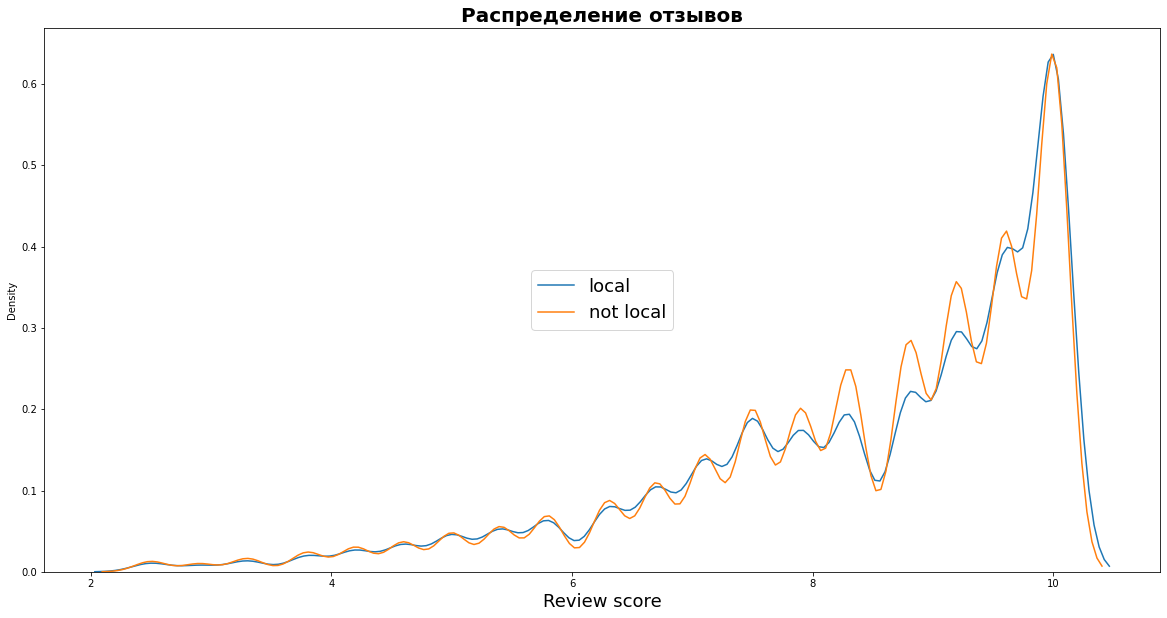

In [83]:
fig, (ax) = plt.subplots(figsize=(20, 10))
ax.set_title('Распределение отзывов', fontweight='bold', fontsize=20)

sns.kdeplot(loc_rev['reviewer_score'], ax=ax, label='local')
sns.kdeplot(not_loc_rev['reviewer_score'], ax=ax, label='not local')
ax.set_xlabel('Review score', fontsize=18)
ax.legend(loc = 'center', fontsize=18);

plt.show()

График показывает, что иностранные посетители ставят несколько выше оценки, чем местные посетители, также видно, что график смещен вправо

In [84]:
# анализ количества оценок от посетителей
display(f"Количество оценок внутренних посетителей {len(loc_rev)}")
display(f"Количество оценок иностранных посетителей {len(not_loc_rev)}")
display('Количество внутернних посетителей меньше, чем иностранных, что соответствует логике')

'Количество оценок внутренних посетителей 131923'

'Количество оценок иностранных посетителей 254880'

'Количество внутернних посетителей меньше, чем иностранных, что соответствует логике'

**Проверка на нормальность**
Построим квантиль-квантиль графики QQ plot

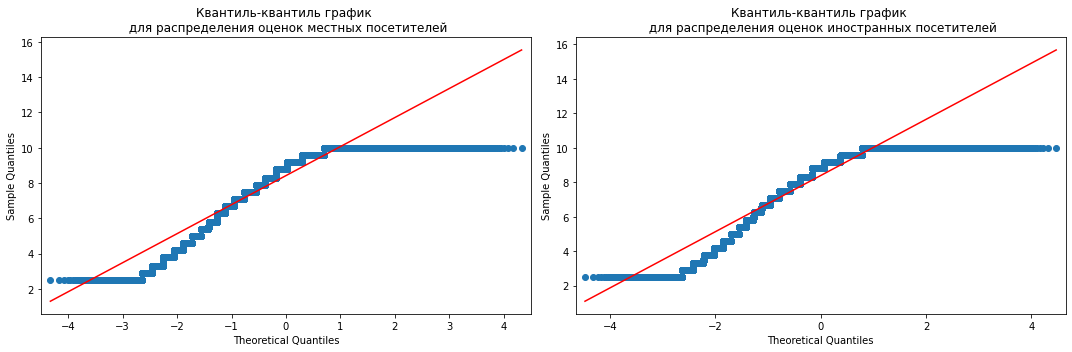

In [85]:
# задаём параметры квантиль-квантиль графика
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sm.qqplot(loc_rev['reviewer_score'], line='s', ax=ax1)
ax1.set_title('Квантиль-квантиль график \n для распределения оценок местных посетителей')

sm.qqplot(not_loc_rev['reviewer_score'], line='s', ax=ax2)
ax2.set_title('Квантиль-квантиль график \n для распределения оценок иностранных посетителей')

plt.tight_layout()
# отображаем квантиль-квантиль график
plt.show()


Графики показывают, что данные не распределены нормально и имеют одинаковый рисунок

1. Определим оставляют ли иностранцы выше оценки, чем оценки внутренних посетителей<br>
*Нулевая гипотеза* ($H_0$): иностранные и внутренние посетители выставляют одинаковые оценки.

$$ H_0 : μ_1 = μ_2$$

<br>*Альтернативная гипотеза* ($H_1$): оценки иностранных посетителей выше, чем оценки внутренних посетителей

$$ H_0 : μ_1 > μ_2$$

In [86]:
# проанализируем длину дата-сетов
print(len(loc_rev['reviewer_score']))
print(len(not_loc_rev['reviewer_score']))
print(len(not_loc_rev['reviewer_score']) - len(loc_rev['reviewer_score']))
#дата-сет со значениями оценок внутренних посетителей дополним на 122 957 медианных значений

131923
254880
122957


In [87]:
# создаем дополнительный список на 127266 значение и заполняем его медианой
df_122957 = np.full(shape = 122957, fill_value = loc_rev['reviewer_score'].median(), dtype = np.int)

# расширяем список на 21 значение
df = loc_rev['reviewer_score']
df_np = pd.DataFrame(df_122957)
ser = df_np.iloc[:,0]
loc_rev_ext = df.append(ser, ignore_index = True)
len(loc_rev_ext)# размер дата-сета соответствует размеру дата-сету иностранных посетителей

C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/2141679383.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_122957 = np.full(shape = 122957, fill_value = loc_rev['reviewer_score'].median(), dtype = np.int)
C:\Users\dmitr\AppData\Local\Temp/ipykernel_4488/2141679383.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loc_rev_ext = df.append(ser, ignore_index = True)


254880

In [88]:
# Распределение оценок инстранных и внутренних посетителей распределены отлично от нормального.
# Тестировать будем две независимые группы. Значит выбраем непараметрический критерий U-критерий Манна — Уитни.
# Для проведения теста необходимо подать на вход два списка значений одинаковой длины.
# Можно в меньший список добавить необходимое количество значений либо сделать выборку из большего списка,
# т.е. отсечь необходимое количество значений
# В рамках данного задания сделаем выборку из большего списка.

_, p = stats.mannwhitneyu(not_loc_rev['reviewer_score'], loc_rev_ext)
decision_gipothesis(p)

print("оценки иностранных посетителей выше, чем оценки внутренних посетителей")

p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
оценки иностранных посетителей выше, чем оценки внутренних посетителей


### Отбор признаков, удаление категориальных признаков.

In [89]:
# в данном дата-сете города и страны равняются один к одному и оба признака будут мультиколиннеарны, удалим страны
list_drop = ['uk', 'france', 'austria', 'spain', 'netherlands', 'italy']
data = data.drop(list_drop, axis=1)

In [90]:
# Сформируем списки категориальных и числовых признаков
obj = [] # список категориальных признаков
num = [] # список числовых признаков
for i in data.columns:
    if data[i].dtypes  == 'object':
        obj.append(i)
    else:
        num.append(i)
print(f'Столбцы "object":\n {obj}')
print()
print(f'Столбцы "numeric":\n {num}')

Столбцы "object":
 ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review', 'country', 'city', 'negative_review_copy', 'positive_review_copy']

Столбцы "numeric":
 ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score', 'duplicates', 'review_month', 'review_year', 'milan', 'amsterdam', 'barcelona', 'london', 'paris', 'vienna', 'country_popul', 'сity_popul', 'diff_popul', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'local_reviewer', 'neg_room', 'neg_location', 'neg_staff', 'neg_eat', 'neg_price', 'neg_wifi', 'neg_bath', 'neg_all', 'pos_room', 'pos_location', 'pos_staff', 'pos_eat', 'pos_price', 'pos_wifi', 'pos_bath', 'pos_all', 'leisure_trip', 'couple', 'so

In [91]:
print(f"Количество категориальных признаков: {len(obj)}")
print(f"Количество числовых признаков: {len(num)}")


Количество категориальных признаков: 11
Количество числовых признаков: 58


Проверим числовые признаки на мультиколлинеарность. Построим тепловую карту корреляции.

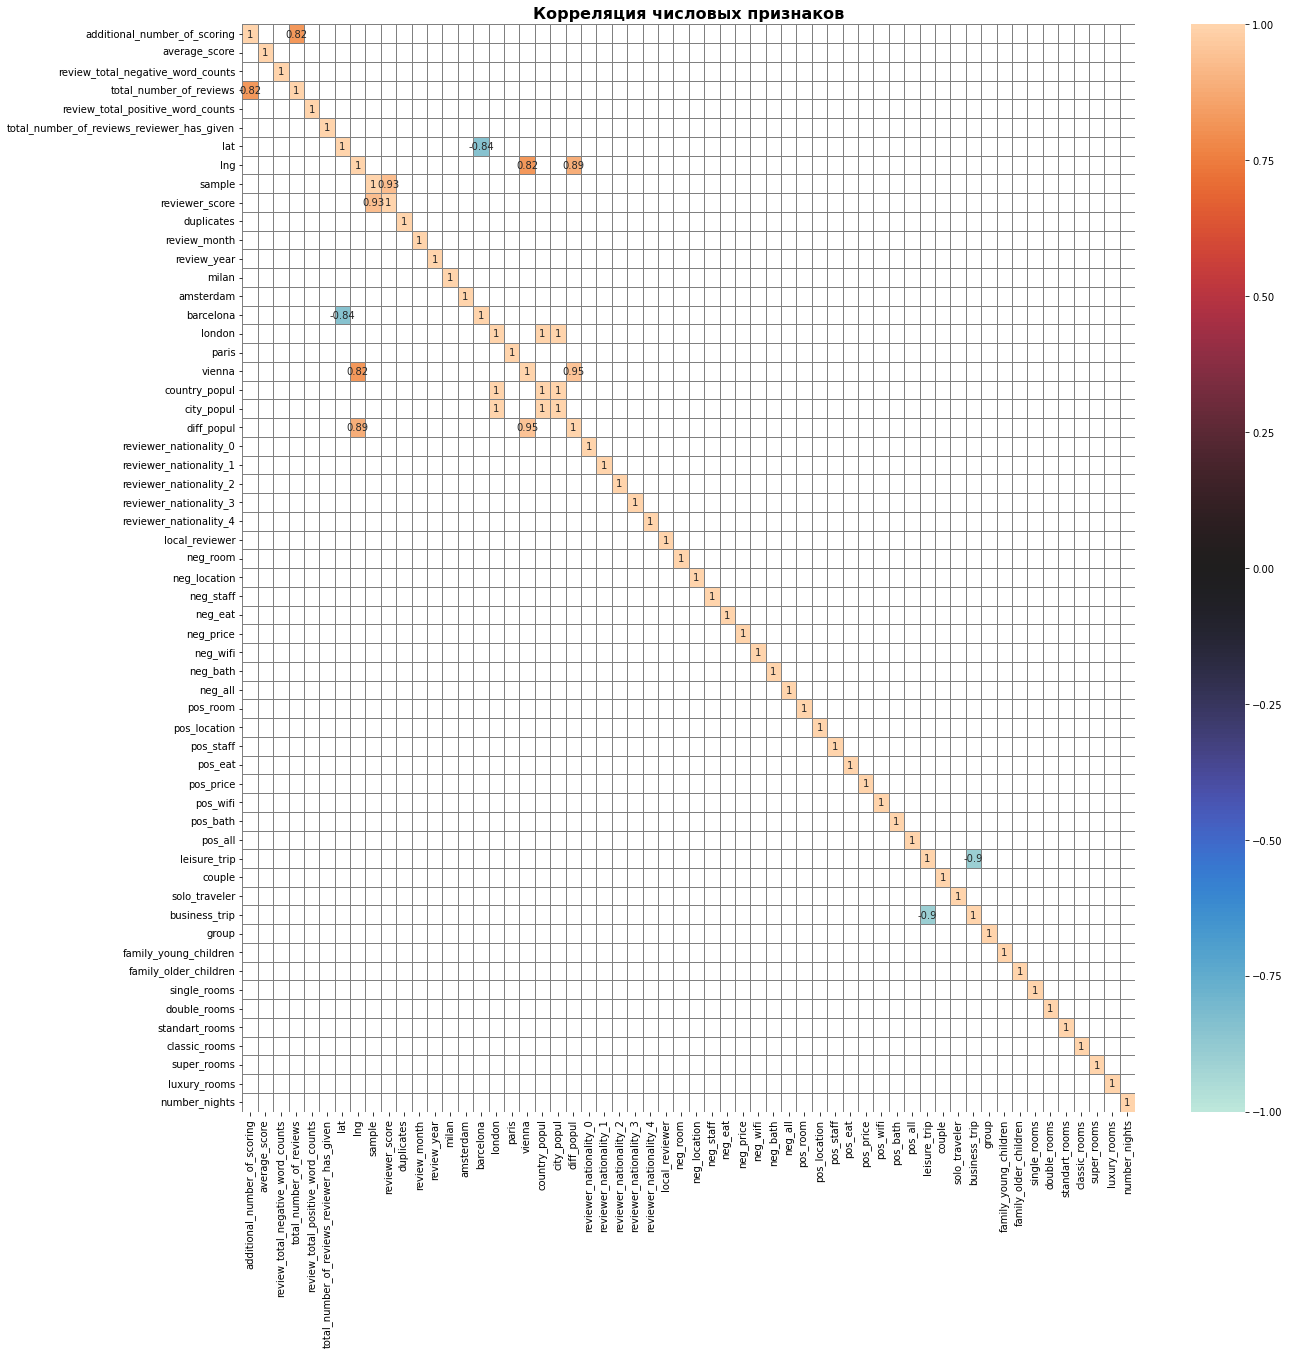

In [92]:
corr = data[num].corr()
corr = corr[np.abs(corr) >= 0.8]

plt.subplots(figsize=(20, 20))
heatmap = sns.heatmap(
    corr, 
    annot=True, 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1, 
    center= 0, 
    linecolor='grey')
heatmap.set_title('Корреляция числовых признаков', fontweight='bold', size=16);

Из карты видно, что мультиколлинеарность некоторых признаков наблюдается. Будем пробовать строить модель, не удаляя признаки.

In [93]:
"""
# Чтобы исключить мультиколлениарность, удалим сильно коррелирующие признаками
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

# Постараемся удалить минимальное количество признаков - удаляем признаки с максимальной корреляцией
print('Признаки, которые были удалены:')
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            print(col)
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
            """

"\n# Чтобы исключить мультиколлениарность, удалим сильно коррелирующие признаками\npivot = data.corr()\npivot = pivot.drop('sample', axis=0)\npivot = pivot.drop('sample', axis=1)\nfor col in pivot:\n    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)\nfor col in pivot:\n    pivot = pivot.dropna(how='all')\n    pivot = pivot.dropna(how='all', axis='columns')\n\n# Постараемся удалить минимальное количество признаков - удаляем признаки с максимальной корреляцией\nprint('Признаки, которые были удалены:')\ncounter = 0\nfor lower_bound in np.linspace(0.98, 0.72, num=14):\n    for col in pivot:\n        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:\n            print(col)\n            pivot = pivot.drop(col, axis=0)\n            pivot = pivot.drop(col, axis=1)\n            data = data.drop(col, axis=1)\n            counter += 1\n            "

In [94]:
# Backup
#data_bkup = data.copy()
#data_bkup.info()
#data = data_bkup.copy()

In [95]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [96]:
# исследуем дата-сет на предмет занимаемой памяти
data.info()
# 216,9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [97]:
# создадим список с наименованием колонок, которые преобразуем из int64 в int8
data_col_64 = pd.concat([data.loc[ : ,'reviewer_nationality_0': ], data.loc[ : , 'duplicates' : 'vienna']], axis=1)
lst_col_64 = list(data_col_64)
print(f'Проверка типа {type(lst_col_64)}')
print(f'Количество значений {len(lst_col_64)}')
#lst_col_64

Проверка типа <class 'list'>
Количество значений 45


In [99]:
# с помощью цикла изменяем тип переменной
for i in lst_col_64:
    data = data.astype({i:np.int8})
    #print(i)

In [100]:
# проверяем дата-сет
data.info()
#65,4 MB, освобождено 151,5 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [101]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [102]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [104]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 57), (386803, 57), (386803, 56), (309442, 56), (77361, 56))

In [105]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [106]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [107]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.3s finished


In [108]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

#mean_absolute_percentage_error

MAPE: 0.8909577908088298


In [109]:
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
display(mape_func(y_test, y_pred))

12.797065831675267

<AxesSubplot:>

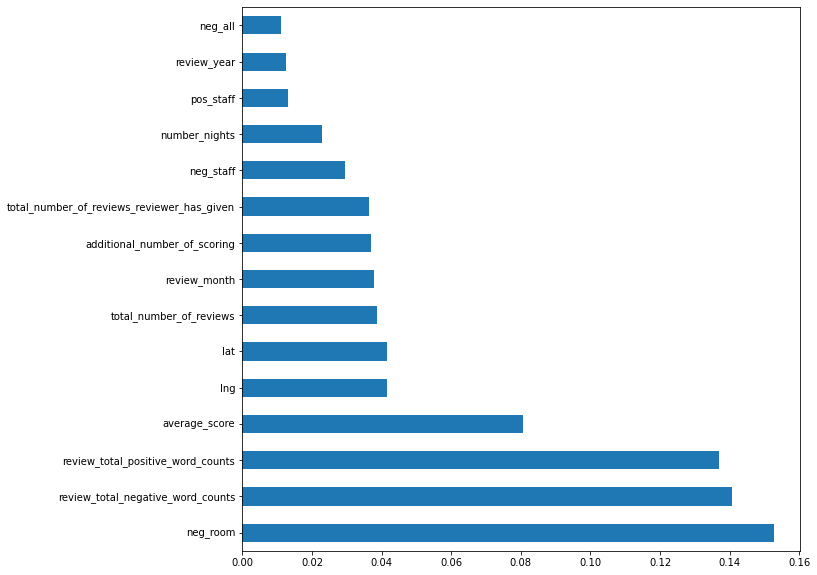

In [110]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [111]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,duplicates,...,group,family_young_children,family_older_children,single_rooms,double_rooms,standart_rooms,classic_rooms,super_rooms,luxury_rooms,number_nights
45665,132,9.3,62,849,35,6,41.393908,2.162256,0.0,0,...,0,1,0,0,0,0,0,0,0,4
91135,332,8.5,5,2708,18,2,41.368437,2.190153,0.0,0,...,0,0,1,0,1,0,0,0,0,2
22332,687,8.9,2,2752,35,1,51.515052,-0.159239,0.0,0,...,0,0,0,0,0,0,0,0,0,2
35493,392,8.6,1,1641,14,5,51.517608,-0.127625,0.0,0,...,0,0,0,0,1,0,0,1,0,1
95733,634,7.9,78,4065,141,2,51.516288,-0.172108,0.0,0,...,0,0,0,0,1,0,0,0,0,1
9204,744,8.3,2,2474,3,6,51.529142,-0.137278,0.0,0,...,0,0,0,0,1,1,0,0,0,2
118617,129,9.2,5,1010,22,1,41.393017,2.164615,0.0,0,...,1,0,0,0,1,1,0,0,0,4
61923,170,8.3,1,1207,21,1,52.359920,4.881013,0.0,0,...,1,0,0,1,0,0,0,0,0,3
60390,215,8.8,17,1420,53,31,52.367757,4.868217,0.0,0,...,0,0,0,0,1,0,0,0,0,3
9576,97,8.1,10,923,27,20,48.861711,2.340674,0.0,0,...,0,0,0,0,0,0,1,0,0,2


In [112]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [113]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [114]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.4s finished


In [115]:
predict_submission

array([8.225, 7.162, 8.721, ..., 7.947, 9.599, 7.273])

In [116]:
list(sample_submission)

['reviewer_score', 'id']

In [117]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission5.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.225,488440
1,7.162,274649
2,8.721,374688
3,9.493,404352
4,9.582,451596
5,8.581,302161
6,7.266,317079
7,7.937,13963
8,8.922,159785
9,7.896,195089
